In [146]:

import numpy as np
import pandas as pd

from config import interim_data_dir, raw_data_dir

from src.utils import read_shapefile

class_labels = pd.read_csv(raw_data_dir / 'crop_id_list.csv', index_col=0)

## Calculate NDVI Time Series

In [320]:
# Number of time stamps
N_ts = 11
# Number of bands
N_b = 10
dataset = 'train'

shp_df = read_shapefile(dataset)
shp_df['class_label'] = shp_df.Crop_Id_Ne.astype(int).replace(class_labels.crop.to_dict())

shp_df.head()

,Area,Subregion,Crop_Id_Ne,geometry,class_label
Field_Id,,,,,
1,0.915905,3,8,"POLYGON ((613924.3324000851 6793991.295069702,...",Vineyard
2,2.064410,3,6,"POLYGON ((614404.0717397591 6794020.579634549,...",Pecan
3,1.080300,3,8,"POLYGON ((614320.2146632321 6793964.242091182,...",Vineyard
4,1.316190,3,8,"POLYGON ((614560.5326844405 6794002.249461887,...",Vineyard
7,5.529220,3,8,"POLYGON ((614596.6564746551 6794269.865436315,...",Vineyard


In [230]:
def load_for_id(farm_id, dataset, bands_subset=None):
    """
    Load all data for a farm
    
    Return:
    
    dictionary: {band: {date: ndarray}, {...}}
    """
    farm_dir = interim_data_dir / 'masks_v2' / dataset / str(farm_id)

    dates = farm_dir.glob('*/')
    farm_data = {}
    
    for date_path in dates:
        
        date = date_path.stem

        bands = date_path.glob("*.npy")
        
        farm_data[date_path.stem] = {}
        
        for band_path in bands:
            band = band_path.stem
            
            if bands_subset and band in bands_subset:
                arr = np.load(band_path)
                farm_data[date][band] = arr
        
    return farm_data

def calc_ndvi(bands_data):
    return np.nan_to_num((bands_data['B08'] - bands_data['B04'])/(bands_data['B08'] + bands_data['B04']))

def calc_ndwi(bands_data):
    return np.nan_to_num((bands_data['B8A'] - bands_data['B11'])/(bands_data['B8A'] + bands_data['B11']))

def agg_arr(arr):
    return arr.flatten().mean()

def calc_vi_ts(farm_data, farm_id, which_vi='ndvi',):
    """
    Calculate vegetation index time series for a farm
    """
    vi_data = {}
    for date, bands_data in farm_data.items():
        vi_data[date] = {}
        vi_data[date] = agg_arr(eval(f'calc_{which_vi}')(bands_data))
        
    vi = pd.DataFrame.from_dict(vi_data, orient='index')
    vi.index = pd.to_datetime(vi.index)
    vi.index.name='time'
    vi.columns = [which_vi]
    
    return pd.concat([vi], keys=[farm_id], names=['farm_id'])

## Calculate average VI per class

And plot time-series aggregated over all farms

In [360]:
%%time

dfs = []
for label, group_df in shp_df.groupby('class_label'):
    
    ids_list = group_df.index.to_list()
    
    # Load only the bands we need
    farms_data = {farm_id: load_for_id(farm_id, dataset, 
                                       bands_subset=['B08','B8A', 'B11','B04']) 
                  for farm_id in ids_list}
    
    vi_dfs = []
    for farm_id, farm_data in farms_data.items():
        ndvi = calc_vi_ts(farm_data, farm_id, 'ndvi')
        ndwi = calc_vi_ts(farm_data, farm_id, 'ndwi')
        
        vi_df = pd.concat([ndvi, ndwi], axis=1)
        
        vi_dfs.append(vi_df)
    
    df = pd.concat(vi_dfs, axis=0)
    df['class'] = label
    
    dfs.append(df)

/Users/renier.botha/anaconda3/envs/zindi_farmpin/lib/python3.7/site-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in true_divide
/Users/renier.botha/anaconda3/envs/zindi_farmpin/lib/python3.7/site-packages/ipykernel_launcher.py:35: RuntimeWarning: invalid value encountered in true_divide


CPU times: user 42.7 s, sys: 10.9 s, total: 53.5 s
Wall time: 1min 22s


In [361]:
df_all = pd.concat(dfs, axis=0)
df_all.reset_index(inplace=True)

,farm_id,time,ndvi,ndwi,class
0,17,2017-01-31,0.410179,0.229821,Cotton
1,17,2017-05-31,0.190296,0.088876,Cotton
2,17,2017-01-01,0.295072,0.125943,Cotton
3,17,2017-02-10,0.410051,0.240934,Cotton
4,17,2017-06-20,0.117468,0.041193,Cotton
5,17,2017-08-04,0.076154,3.644920,Cotton
6,17,2017-07-10,0.101918,0.031925,Cotton
7,17,2017-08-19,0.088046,1.600370,Cotton
8,17,2017-07-15,0.112325,0.192782,Cotton
9,17,2017-03-22,0.295567,0.178787,Cotton


In [240]:
agg_df = df_all.groupby(['class','time']).agg({'ndvi': 'median', 'ndwi': 'median'}).reset_index()
agg_df.time = pd.to_datetime(agg_df.time)
agg_df.sort_values(by=['class','time'], inplace=True)

agg_df.head(20)

,class,time,ndvi,ndwi
0,Cotton,2017-01-01,0.214980,0.078563
1,Cotton,2017-01-31,0.325277,0.180664
2,Cotton,2017-02-10,0.256353,0.144628
3,Cotton,2017-03-12,0.316102,0.169123
4,Cotton,2017-03-22,0.282615,0.140477
5,Cotton,2017-05-31,0.135634,0.035936
6,Cotton,2017-06-20,0.100493,1.154438
7,Cotton,2017-07-10,0.095691,2.602683
8,Cotton,2017-07-15,0.103384,2.367422
9,Cotton,2017-08-04,0.060484,3.797484


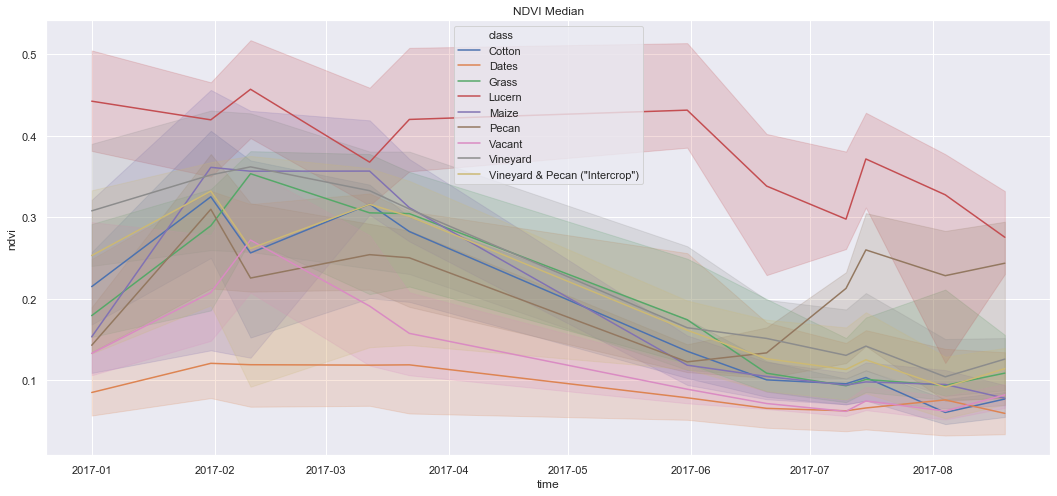

In [259]:
import seaborn as sns
sns.set()

fig, ax = plt.subplots(figsize=(18,8))
sns.lineplot(data=df_all, x='time',y='ndvi', hue='class', ax=ax, estimator=np.median, )
ax.set_title('NDVI Median')
ax.legend(loc='best')

In [362]:
df_all.time = pd.to_datetime(df_all.time)
df_all = df_all.sort_values(by=['farm_id','time'])
df_all.head(11)

,farm_id,time,ndvi,ndwi,class
16238,1,2017-01-01,0.321488,0.172700,Vineyard
16236,1,2017-01-31,0.343804,0.171819,Vineyard
16239,1,2017-02-10,0.357041,0.200444,Vineyard
16246,1,2017-03-12,0.319987,0.163100,Vineyard
16245,1,2017-03-22,0.315502,0.173627,Vineyard
16237,1,2017-05-31,0.118422,3.564937,Vineyard
16240,1,2017-06-20,0.112302,5.361134,Vineyard
16242,1,2017-07-10,0.117899,6.045269,Vineyard
16244,1,2017-07-15,0.133403,5.746671,Vineyard
16241,1,2017-08-04,0.104115,5.361965,Vineyard


In [365]:
data = np.ndarray((len(shp_df),11, 1))
classes = {}
for i, (farm_id, farm_df) in enumerate(df_all.groupby(['farm_id'])):
    
    data[i,:,:] = farm_df[['ndvi']].values
    
    c = farm_df['class'].unique()
    
    classes[i] = c[0]
    

In [385]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

labels = list(classes.values())
indexes = list(classes.keys())
train_idx, val_idx, train_labels, val_labels = train_test_split(indexes, labels, stratify=labels,)

le = LabelEncoder()
train_labels_enc = le.fit_transform(np.array(train_labels).reshape(-1,1))
val_labels_enc = le.transform(np.array(val_labels).reshape(-1,1))

train_data = data[train_idx,:, :]
val_data = data[val_idx,:, :]

print('train data : ',train_data.shape)
print('val data : ',val_data.shape)

train data :  (1870, 11, 1)
val data :  (624, 11, 1)


/Users/renier.botha/anaconda3/envs/zindi_farmpin/lib/python3.7/site-packages/sklearn/preprocessing/label.py:235: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/renier.botha/anaconda3/envs/zindi_farmpin/lib/python3.7/site-packages/sklearn/preprocessing/label.py:252: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [389]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import models, layers
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ReduceLROnPlateau

from src.visualization.tf_viz import PlotLosses

es = EarlyStopping(monitor='val_loss', verbose=1, patience=50)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', patience=35, verbose=1)

plot_losses = PlotLosses()

def get_model():

    model = models.Sequential()
    model.add(layers.GRU(4, input_shape=(11, 1)))
    model.add(layers.Flatten())
    model.add(layers.Dense(9, activation='softmax'))
    
    return model


model = get_model()
optimizer = keras.optimizers.Adam(learning_rate=0.003)
model.compile(optimizer='adam',
              loss=keras.metrics.sparse_categorical_crossentropy,
              metrics=[keras.metrics.sparse_categorical_crossentropy])

model.summary()

Model: "sequential_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_11 (GRU)                 (None, 4)                 84        
_________________________________________________________________
flatten_10 (Flatten)         (None, 4)                 0         
_________________________________________________________________
dense_10 (Dense)             (None, 9)                 45        
Total params: 129
Trainable params: 129
Non-trainable params: 0
_________________________________________________________________


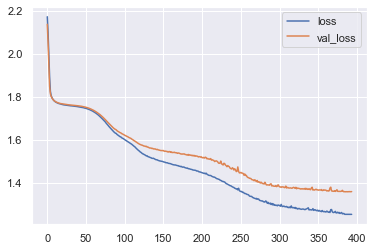


Epoch 00394: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.
1870/1870 - 0s - loss: 1.2547 - sparse_categorical_crossentropy: 1.2547 - val_loss: 1.3606 - val_sparse_categorical_crossentropy: 1.3606
Epoch 00394: early stopping


In [390]:
model.fit(train_data, 
          train_labels_enc,
          batch_size=64,
          validation_data=(val_data, val_labels_enc), 
          verbose=2,
          epochs=1000,
          callbacks=[plot_losses, es, reduce_lr])

In [405]:
from sklearn.metrics import log_loss

val_preds = model.predict(val_data)
train_preds = model.predict(train_data)
print('val loss: ',log_loss(val_labels_enc, val_preds))
print('train loss: ',log_loss(train_labels_enc, train_preds))

val loss:  1.3605600931944373
train loss:  1.2541435701882138


In [391]:
dataset='test'
shp_df = read_shapefile(dataset)

ids_list = shp_df.index.to_list()

# Load only the bands we need
farms_data = {farm_id: load_for_id(farm_id, dataset, bands_subset=['B08','B8A', 'B11','B04']) for farm_id in ids_list}

vi_dfs = []
for farm_id, farm_data in farms_data.items():
    ndvi = calc_vi_ts(farm_data, farm_id, 'ndvi')
    ndwi = calc_vi_ts(farm_data, farm_id, 'ndwi')

    vi_df = pd.concat([ndvi, ndwi], axis=1)

    vi_dfs.append(vi_df)

test_df = pd.concat(vi_dfs, axis=0)

/Users/renier.botha/anaconda3/envs/zindi_farmpin/lib/python3.7/site-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in true_divide
/Users/renier.botha/anaconda3/envs/zindi_farmpin/lib/python3.7/site-packages/ipykernel_launcher.py:35: RuntimeWarning: invalid value encountered in true_divide


In [407]:
test_df = test_df.reset_index()
test_df.time = pd.to_datetime(test_df.time)

test_df = test_df.sort_values(by=['farm_id','time'])

test_df.head(10)

,farm_id,time,ndvi,ndwi
2,5,2017-01-01,0.174937,0.093178
0,5,2017-01-31,0.196083,0.101313
3,5,2017-02-10,0.196436,0.104894
10,5,2017-03-12,0.182643,0.088816
9,5,2017-03-22,0.155640,0.071433
1,5,2017-05-31,0.110762,0.027643
4,5,2017-06-20,0.095521,0.679590
6,5,2017-07-10,0.087682,0.786099
8,5,2017-07-15,0.096719,0.788871
5,5,2017-08-04,0.057626,1.772615


In [408]:
test_data = np.ndarray((len(shp_df),11, 1))

for i, (farm_id, farm_df) in enumerate(test_df.groupby(['farm_id'])):
    
    test_data[i, :,:] = farm_df[['ndvi']].values
    
test_data.shape

(1074, 11, 1)

In [409]:
def make_sub(predictions, ids_list):
    
    sub_df = pd.read_csv(raw_data_dir / 'sample_submission_fixed.csv')

    new_sub = sub_df.copy().set_index('field_id')

    new_sub.loc[ids_list] = predictions
    
    return new_sub

predictions = model.predict(test_data)
sub_df = make_sub(predictions, ids_list)
sub_df.head()

,crop_id_1,crop_id_2,crop_id_3,crop_id_4,crop_id_5,crop_id_6,crop_id_7,crop_id_8,crop_id_9
field_id,,,,,,,,,
5,0.050233,0.000609,0.035577,0.078153,0.013335,0.076246,0.070076,0.645666,0.030104
6,0.053082,0.000453,0.036957,0.115335,0.000597,0.068046,0.013970,0.656704,0.054857
10,0.043723,0.000565,0.036728,0.148028,0.000446,0.071767,0.015261,0.626051,0.057431
18,0.065375,0.000339,0.038717,0.086971,0.001230,0.061633,0.016319,0.682730,0.046687
23,0.075658,0.000282,0.039474,0.070285,0.001914,0.057702,0.017224,0.695058,0.042403


In [410]:
from config import subs_dir

sub_df.to_csv(subs_dir / 'gru_ndvi_baseline.csv')

In [404]:
predictions.shape

(1074, 9)